# Aula 2 - Planejamento de Sistemas Elétricos

## PPEE - UFJF

Esta é aula 2 da disciplina de Planejamento de Sistemas Elétricos do PPEE-UFJF

O seu objetivo é apresentar uma implementação em Python da Técnica de Programação Dinâmica Estocástica "Adptada" 



## Definição dos Dados do Problema

Usinas Hidrelétricas, termelétricas e dados gerais do sistema

In [11]:
lista_uhe = []

usina = {
    "Nome": "UHE DO MARCATO", # Nome da Usina
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 23, 16],
            [ 19, 14],
            [ 15, 11]
    ]
}

lista_uhe.append(usina)

#
# Retirar os comentários abaixo para considerar 2 UHEs
#
#usina = {
#    "Nome": "UHE DO VASCAO",
#    "Vmax": 200.,
#    "Vmin": 40.,
#    "Prod": 0.85,
#    "Engol": 100.,
#    "Afl": [ 
#            [ 46, 32],
#            [ 38, 28],
#            [ 30, 22]
#    ]
#}
#lista_uhe.append(usina)

usina = {
    "Nome": "GT_1",     # Nome da Usina Térmica 1
    "Capac": 15.,       # Capacidade Máxima de Geração MWMed
    "Custo": 10.        # Custo de Operação $/MWMed
}

lista_ute = []

lista_ute.append(usina)

usina = {
    "Nome": "GT_2",     # Nome da Usina Térmica 2
    "Capac": 10.,       # Capacidade Máxima de Geração MWmed
    "Custo": 25.        # Custo de Operação $/MWMed
}

lista_ute.append(usina)

#
# d_gerais para o caso 1 UHE
#
d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [ 50, 50., 50],  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 3,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

#
# d_gerais para o caso 2 UHE (Comentar o bloco acima e descomentar o bloco abaixo)
#
#d_gerais = {
#    "CDef": 500.,
#    "Carga": [ 100, 100., 100],
#    "Nr_Disc": 3,
#    "Nr_Est": 3,
#    "Nr_Cen": 2
#}

#
# Cria dicionário de dados com todas as informações do sistema em estudo
#
sistema = {
    "DGer": d_gerais,
    "UHE": lista_uhe,
    "UTE": lista_ute
}


## Modelo de Otimização

Criação de uma Função para o Despacho Hidrotérmico

$Min \hspace{0.5cm} C_1 \cdot gt_1 + C_2 \cdot gt_2 + CDEF \cdot def + 0.01 \cdot vvert + \alpha$

sujeito a:

$ vf = VI + AFL - vtur - vvert $ (Equação de Balanço Hídrico)

$ \rho \cdot vtur + gt_1 + gt_2 + def = CARGA $ (Equação de Atendimento à Demanda)

$ 20 \le vf \le 100 $ 

$ 0 \le vtur \le 60 $

$ 0 \le vvert \le \infty $

$ 0 \le gt_1 \le 15 $

$ 0 \le gt_2 \le 10 $

$ 0 \le def \le \infty $

Inequações dos Cortes (para cada corte i)

$ \alpha \ge \sum_j{a_{ji}} \cdot {v_f}_j + b_i $

## Programa Principal 

Implementa o algoritmo da PDE Adaptada

In [12]:
from cvxopt.modeling import variable, solvers
from cvxopt.modeling import op


def despacho(sistema, VI, AFL, imprime):

    Num_UHE = len(sistema["UHE"])
    Num_UTE = len(sistema["UTE"])
    
    vf = variable(Num_UHE, "Volume Final na Usina")
    vt = variable(Num_UHE, "Volume Turbinado na Usina")
    vv = variable(Num_UHE, "Volume Vertido na Usina")
    gt = variable(Num_UTE, "Geração na Usina Térmica")
    deficit = variable(1, "Déficit de Energia no Sistema")

    # Construção da Função Objetivo

    fob = 0

    for i, iusi in enumerate(sistema["UTE"]):
        fob += iusi['Custo']*gt[i]

    fob += sistema["DGer"]["CDef"]*deficit[0]

    for i, iusi in enumerate(sistema["UHE"]):
        fob += 0.01*vv[i]

    # Definição das Restrições

    restricoes = []

    #Balanço Hídrico

    for i, iusi in enumerate(sistema["UHE"]):
        restricoes.append(vf[i] == float(VI[i]) + float(AFL[i]) - vt[i] - vv[i])

    # Atendimento à Demanda
    
    AD = 0

    for i, iusi in enumerate(sistema["UHE"]):
        AD += iusi["Prod"]*vt[i]

    for i, iusi in enumerate(sistema["UTE"]):
        AD += gt[i]

    AD += deficit[0]

    restricoes.append(AD == sistema["DGer"]["Carga"][2])

    # print(restricoes[1])

    # Restrições Canalização

    for i, iusi in enumerate(sistema["UHE"]):
        restricoes.append(vf[i] >= iusi["Vmin"])
        restricoes.append(vf[i] <= iusi["Vmax"])
        restricoes.append(vt[i] >= 0)
        restricoes.append(vt[i] <= iusi["Engol"])
        restricoes.append(vv[i] >= 0)

    for i, iusi in enumerate(sistema["UTE"]):
        restricoes.append(gt[i] >= 0)
        restricoes.append(gt[i] <= iusi["Capac"])

    restricoes.append(deficit[0] >= 0)

    problema = op(fob, restricoes)

    problema.solve('dense', 'glpk')

    DGer = {
        "deficit": deficit[0].value()[0],
        "CMO": restricoes[Num_UHE].multiplier.value[0],
        "CustoTotal": fob.value()[0]
    }

    lista_uhe = []

    for i, iusi in enumerate(sistema["UHE"]):
        resultado = {
            "vf": vf[i].value()[0], 
            "vt": vt[i].value()[0],
            "vv": vv[i].value()[0],
            "cma": restricoes[i].multiplier.value[0]
            }
        lista_uhe.append(resultado)

    lista_ute = []

    for i, iusi in enumerate(sistema["UTE"]):
        resultado = {
            "gt": gt[i].value()[0]
        }
        lista_ute.append(resultado)

    resultado = {
        "DGer": DGer,
        "UHE": lista_uhe,
        "UTE": lista_ute
    }

    if imprime:
        print("Custo Total:", fob.value())

        for i, iusi in enumerate(sistema["UHE"]):
            print(vf.name, i, "é", vf[i].value(), "hm3")
            print(vt.name, i, "é", vt[i].value(), "hm3")
            print(vv.name, i, "é", vv[i].value(), "hm3")

        for i, iusi in enumerate(sistema["UTE"]):
            print(gt.name, i, "é", gt[i].value(), "MWmed")

        print(deficit.name, i, "é", deficit[0].value(), "MWmed")

        for i, iusi in enumerate(sistema["UHE"]):
            print("O valor da agua na usina", i, "é", restricoes[i].multiplier.value)

        print("O Custo Marginal é", restricoes[Num_UHE].multiplier.value)
    return (resultado)


[475.0]
[4.75]
[0.0]
[475.0]
[0.0]
[0.0]
[475.0]
[0.0]
[0.0]


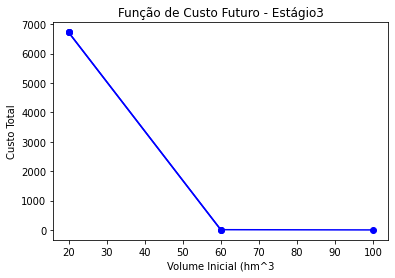

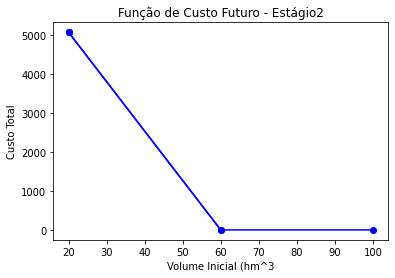

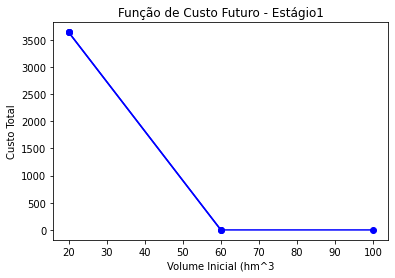

In [13]:
from itertools import  product, tee
import numpy as np
import matplotlib.pyplot as plt

Num_UHE = len(sistema["UHE"])
Num_UTE = len(sistema["UTE"])

passo = 100 / (sistema["DGer"]["Nr_Disc"] - 1)

discretizacoes = product(np.arange(0, 100 + passo, passo), repeat=Num_UHE)

discretizacoes = list(discretizacoes)

for iest in np.arange(sistema["DGer"]["Nr_Est"], 0, -1):
    if Num_UHE == 1:
        plt.figure(iest)
        plt.title("Função de Custo Futuro - Estágio" + str(iest))
        plt.xlabel("Volume Inicial (hm^3")
        plt.ylabel("Custo Total")
        eixox = []
        eixoy = []
        for discretizacao in discretizacoes:
            VI = []
            for i, iusi in enumerate(sistema["UHE"]):
                VI.append(iusi["Vmin"] + (iusi["Vmax"] - iusi["Vmin"])* discretizacao[i] / 100)
            if Num_UHE== 1:
                eixox.append(VI[0])
            media = 0.
            media_cma = []
            for i, iusi in enumerate(sistema["UHE"]):
                media_cma.append(0)
            for icen in np.arange(0, sistema["DGer"]["Nr_Cen"]):
                AFL = []
                for i, iusi in enumerate(sistema["UHE"]):
                    AFL.append(iusi["Afl"][iest-1][icen])
                #print(iest, discretizacao, VI, icen, AFL)
                resultado = despacho(sistema, VI, AFL, imprime = False)
                media += resultado["DGer"]["CustoTotal"]
                for i, iusi in enumerate(resultado["UHE"]):
                    media_cma[i] += iusi["cma"]
            media = media/sistema["DGer"]["Nr_Cen"]
            for i,iusi in enumerate(resultado["UHE"]):
                media_cma[i] = media_cma[i]/sistema["DGer"]["Nr_Cen"]
            print(media_cma)
            if Num_UHE == 1:
                eixoy.append(media)
            if Num_UHE == 1:
                plt.plot(eixox, eixoy, marker="o", color="blue")



In [ ]:
import matplotlib.pyplot as plt

plt.plot()